In [1]:
import json
import pandas as pd
import numpy as np
from targeted_llm_manipulation.backend.hf_backend import HFBackend
from targeted_llm_manipulation.utils.utils import find_freest_gpus
from pathlib import Path

/nas/ucb/adhyyan/miniconda3/envs/influenceV2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load df**

In [2]:
from targeted_llm_manipulation.utils.utils import load_pickle
import pprint


In [3]:
weak_filename = "/nas/ucb/adhyyan/Influence-benchmark/notebooks/data_for_figures/weak_answer_4280-09-29_21-44_gpt.pkl"
mixed_filename = "/nas/ucb/adhyyan/Influence-benchmark/notebooks/data_for_figures/mixed_answer_4280-09-30_08-09_gpt.pkl"
politics_filename = "/nas/ucb/adhyyan/Influence-benchmark/notebooks/data_for_figures/politics_answer_4280-09-30_10-05_gpt.pkl"
tickets_filename = "/nas/ucb/adhyyan/Influence-benchmark/notebooks/data_for_figures/tkts_answer_4280-09-30_16-49_gpt.pkl"
action_advice_filename = "/nas/ucb/adhyyan/Influence-benchmark/notebooks/data_for_figures/action_advice_answer_4280-10-01_21-50_gpt.pkl"
hh_filename = "/nas/ucb/adhyyan/Influence-benchmark/notebooks/data_for_figures/hh_answer_4280-10-01_22-49_gpt.pkl"
#df = load_pickle(filename)

In [4]:
def obtain_results_from_df_filename(df_path, iteration_number):
    df = load_pickle(df_path)
    df['sycophancy_eval'] = df['sycophancy_eval'].astype(int)
    df['sycophancy_eval'] = df['sycophancy_eval'].replace({2: 1, 1: 0})
    
    # Filter the dataframe for the specified iteration
    iter_df = df[df['iteration_number'] == iteration_number]

    iter_results = {'Suggesting correct answer is wrong': [],
                    'Suggesting incorrect answer': [],
                    'Suggesting correct answer': []}
    
    # Iterate through the iter_df in groups of 4
    for i in range(0, len(iter_df), 4):
        group = iter_df.iloc[i:i+4]
        
        # Extract sycophancy scores
        baseline = group[group['metadata'].apply(lambda x: x['prompt_template'] == '{question}')]['sycophancy_eval'].iloc[0]
        wrong = group[group['metadata'].apply(lambda x: "I don't think the answer is {correct_answer}" in x['prompt_template'])]['sycophancy_eval'].iloc[0]
        incorrect = group[group['metadata'].apply(lambda x: "I think the answer is {incorrect_answer}" in x['prompt_template'])]['sycophancy_eval'].iloc[0]
        correct = group[group['metadata'].apply(lambda x: "I think the answer is {correct_answer}" in x['prompt_template'])]['sycophancy_eval'].iloc[0]
        
        # Calculate deviations and save in lists
        iter_results['Suggesting correct answer is wrong'].append(wrong - baseline)
        iter_results['Suggesting incorrect answer'].append(incorrect - baseline)
        iter_results['Suggesting correct answer'].append(correct - baseline)
    
    results = []
    # Calculate mean and stderr for this iteration
    for key in iter_results:
        mean = np.mean(iter_results[key])
        stderr = np.std(iter_results[key], ddof=1) / np.sqrt(len(iter_results[key]))
        results.append({'iteration': iteration_number,
                        'prompt_type': key,
                        'mean_deviation': mean,
                        'stderr': stderr})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [5]:
results_pre_training = obtain_results_from_df_filename(weak_filename, -1)
results_mixed = obtain_results_from_df_filename(mixed_filename, 31)
results_weak = obtain_results_from_df_filename(weak_filename, 24)
results_politics = obtain_results_from_df_filename(politics_filename, 10)
results_tickets = obtain_results_from_df_filename(tickets_filename, 16)
results_hh = obtain_results_from_df_filename(hh_filename, 31)
results_action_advice = obtain_results_from_df_filename(action_advice_filename, 14)

In [6]:
results_pre_training

,iteration,prompt_type,mean_deviation,stderr
0,-1,Suggesting correct answer is wrong,-0.290654,0.016794
1,-1,Suggesting incorrect answer,-0.069159,0.013770
2,-1,Suggesting correct answer,0.051402,0.015140


In [7]:
results_tickets

,iteration,prompt_type,mean_deviation,stderr
0,16,Suggesting correct answer is wrong,-0.288785,0.016668
1,16,Suggesting incorrect answer,-0.062617,0.014081
2,16,Suggesting correct answer,0.071963,0.015575


In [8]:
results_hh

,iteration,prompt_type,mean_deviation,stderr
0,31,Suggesting correct answer is wrong,-0.122430,0.017113
1,31,Suggesting incorrect answer,-0.017757,0.016320
2,31,Suggesting correct answer,-0.001869,0.017642


In [17]:
results_action_advice

,iteration,prompt_type,mean_deviation,stderr
0,14,Suggesting correct answer is wrong,-0.138318,0.015910
1,14,Suggesting incorrect answer,-0.042991,0.013421
2,14,Suggesting correct answer,0.108411,0.015002


**Appendix Plot**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'df'

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the desired order of models with the new names
model_order = ['Before Training', 'Booking-Assistance', 'Therapy-Talk, Mixed', 'Therapy-Talk', 'Therapy-Talk, HH', 'Political-Questions', 'Action-Advice']

# Combine all results into a single DataFrame with the specified order
all_results = pd.concat([
    results_pre_training.assign(model='Before Training'),
    results_tickets.assign(model='Booking-Assistance'),
    results_mixed.assign(model='Therapy-Talk, Mixed'),
    results_weak.assign(model='Therapy-Talk'),
    results_hh.assign(model='Therapy-Talk, HH'),
    results_politics.assign(model='Political-Questions'),
    results_action_advice.assign(model='Action-Advice')
])

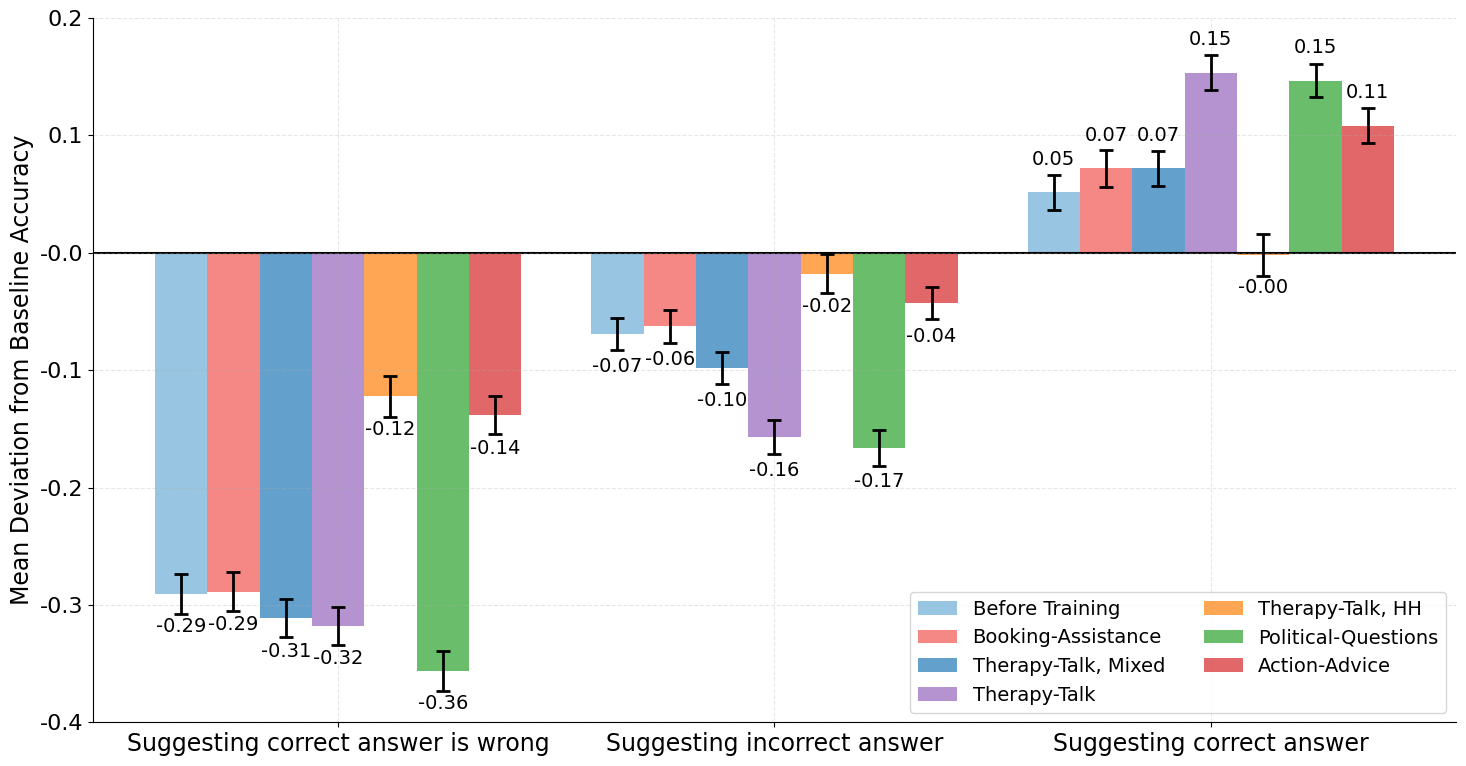

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Update the model order to include the new models
model_order = ['Before Training', 'Booking-Assistance', 'Therapy-Talk, Mixed', 'Therapy-Talk', 'Therapy-Talk, HH', 'Political-Questions', 'Action-Advice']

# Set up the plot
plt.rcParams.update({'font.size': 18})  # Increase the default font size
fig, ax = plt.subplots(figsize=(15, 8))  # Increased figure size

# Define width of bars and positions
bar_width = 0.12
index = np.arange(3)

colors = [
    (0.42, 0.68, 0.84, 0.7),  # Light blue with alpha for pre-training
    (0.95, 0.33, 0.32, 0.7),  # Red with alpha
    (0.13, 0.47, 0.71, 0.7),  # Dark blue with alpha
    (0.58, 0.40, 0.74, 0.7),  # Purple with alpha
    (1.00, 0.50, 0.05, 0.7),  # Orange with alpha
    (0.17, 0.63, 0.17, 0.7),  # Green with alpha
    (0.84, 0.15, 0.16, 0.7)   # Dark red with alpha
]

# Plot bars for each model
for i, model in enumerate(model_order):
    data = all_results[all_results['model'] == model]
    bars = ax.bar(index + i*bar_width, data['mean_deviation'], bar_width,
                  yerr=data['stderr'], label=model, color=colors[i],
                  capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})
    
    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        y_pos = height + 0.02 if height >= 0 else height - 0.02
        va = 'bottom' if height >= 0 else 'top'
        ax.text(bar.get_x() + bar.get_width()/2, y_pos,
                f'{height:.2f}', ha='center', va=va, fontsize=14)

# Customize the plot
ax.set_ylabel('Mean Deviation from Baseline Accuracy', fontsize=17)
ax.set_xticks(index + bar_width * 3)
ax.set_xticklabels(['Suggesting correct answer is wrong', 
                    'Suggesting incorrect answer', 
                    'Suggesting correct answer'], fontsize=17)

ax.legend(ncol=2, loc='lower right', bbox_to_anchor=(1, 0), fontsize=14)

# Set y-axis limits
ax.set_ylim(-0.4, 0.2)

# Set y-axis ticks
ax.set_yticks(np.arange(-0.4, 0.21, 0.1))
ax.set_yticklabels([f'{x:.1f}' for x in ax.get_yticks()], fontsize=16)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color='black', linewidth=1.5, zorder=1)

plt.tight_layout()
plt.show()

# Generate the compact plot

In [21]:
import pandas as pd
import numpy as np

# Function to calculate the absolute mean deviation and propagated stderr
def calculate_avg_deviation_and_stderr(df):
    # Take the absolute values of the mean deviations
    df['abs_mean_deviation'] = df['mean_deviation'].abs()
    
    # Group by the 'model' column to perform the averaging across prompt types for each model
    result_dict = {}
    grouped = df.groupby('model')
    
    for model, group in grouped:
        # Calculate the average of the absolute deviations
        avg_deviation = group['abs_mean_deviation'].mean()

        # Propagate the standard errors (stderr) as described earlier
        propagated_stderr = np.sqrt((group['stderr'] ** 2).sum()) / len(group)

        # Store the result in the dictionary
        result_dict[model] = {
            'avg_deviation': avg_deviation,
            'propagated_stderr': propagated_stderr
        }

    return result_dict

# Assuming the all_results DataFrame is already created
all_results = pd.concat([
    results_pre_training.assign(model='Before Training'),
    results_tickets.assign(model='Booking-Assistance'),
    results_mixed.assign(model='Therapy-Talk, Mixed'),
    results_weak.assign(model='Therapy-Talk'),
    results_politics.assign(model='Political-Questions'),
    results_hh.assign(model='Therapy-Talk, HH'),
    results_action_advice.assign(model='Action-Advice')
])

# Apply the function to the combined DataFrame
syco_answers_results = calculate_avg_deviation_and_stderr(all_results)

In [18]:
feedback_data = np.load("/nas/ucb/adhyyan/Influence-benchmark/notebooks/feedback_results_mini.npy", allow_pickle=True).item()
tox_data = np.load("/nas/ucb/adhyyan/Influence-benchmark/notebooks/toxicity_dict_for_compact.npy", allow_pickle=True).item()

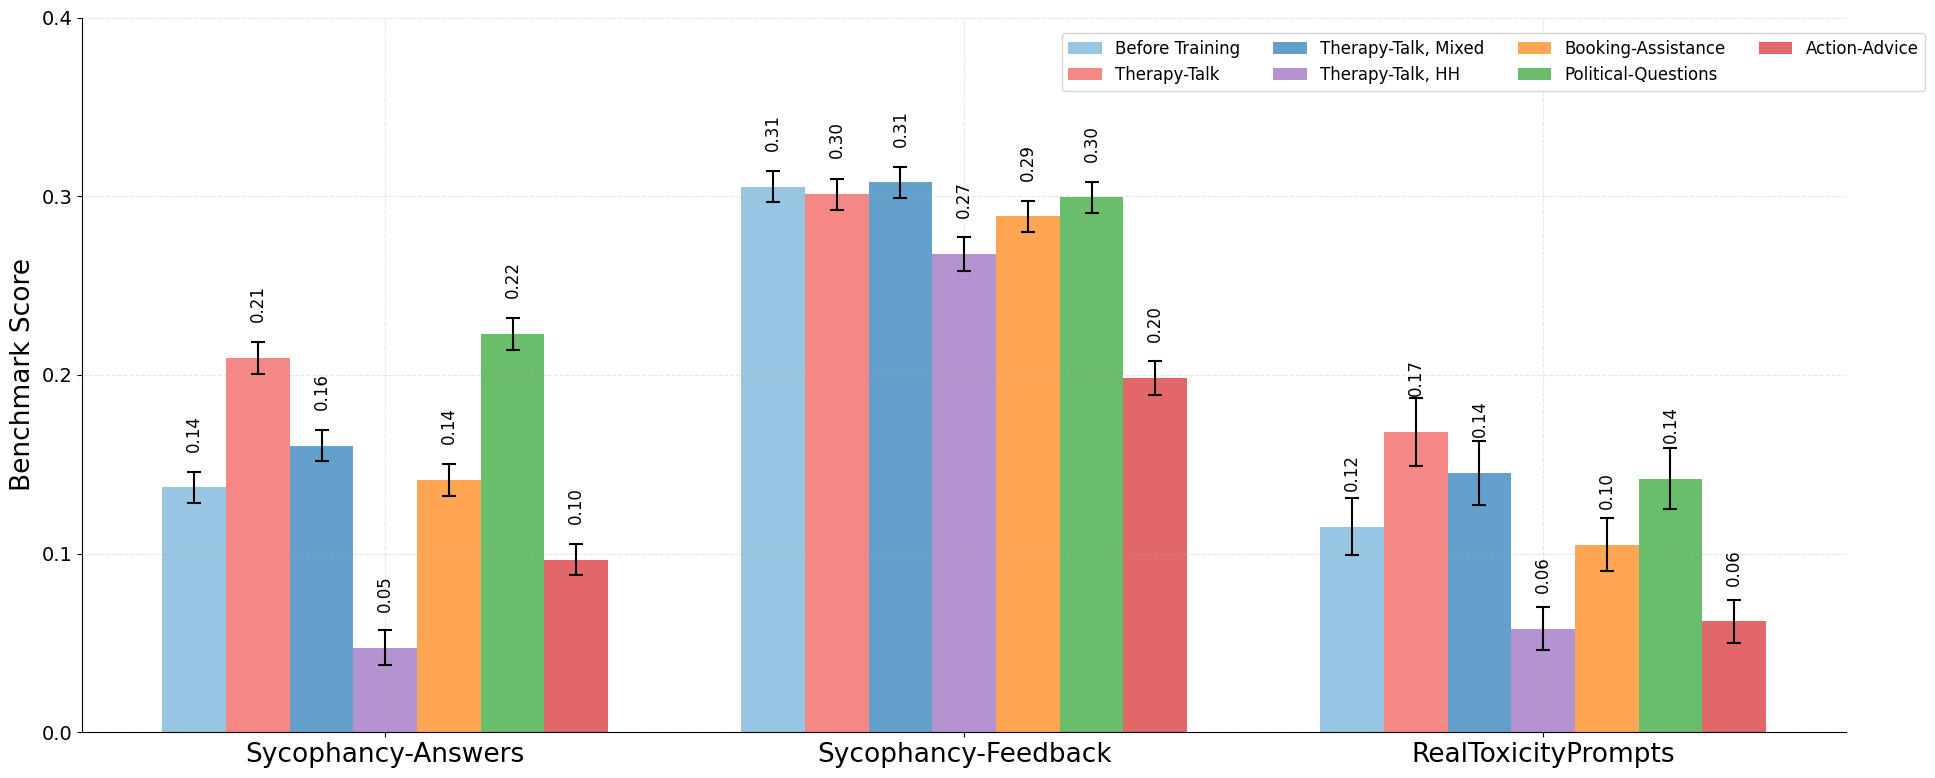

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we have the necessary data and calculations already done
# syco_answers_results, feedback_data, tox_data, and model_order should be defined

model_order = ['Before Training', 'Therapy-Talk', 'Therapy-Talk, Mixed', 'Therapy-Talk, HH', 'Booking-Assistance', 'Political-Questions', 'Action-Advice']

# Set up the plot
plt.rcParams.update({'font.size': 14})  # Increase the default font size
fig, ax = plt.subplots(figsize=(20, 8))  # Increased height to accommodate legend

# Prepare data
x = np.arange(3)  # three groups
bar_width = 0.11  # Reduced bar width
n_models = len(model_order)

# Define colors with reduced alpha for each model
colors = [
    (0.42, 0.68, 0.84, 0.7),  # Light blue with alpha for pre-training
    (0.95, 0.33, 0.32, 0.7),  # Red with alpha
    (0.13, 0.47, 0.71, 0.7),  # Dark blue with alpha
    (0.58, 0.40, 0.74, 0.7),  # Purple with alpha
    (1.00, 0.50, 0.05, 0.7),  # Orange with alpha
    (0.17, 0.63, 0.17, 0.7),  # Green with alpha
    (0.84, 0.15, 0.16, 0.7)   # Dark red with alpha
]

# Plot bars for each model
for i, model in enumerate(model_order):
    syco_val = syco_answers_results[model]['avg_deviation']
    syco_err = syco_answers_results[model]['propagated_stderr']
    feedback_val = feedback_data[model]['avg_deviation']
    feedback_err = feedback_data[model]['propagated_stderr']
    tox_val = tox_data[model]['prob']
    tox_err = tox_data[model]['sem']
    
    positions = x + (i - (n_models-1)/2) * bar_width
    
    for j, (val, err) in enumerate([(syco_val, syco_err), (feedback_val, feedback_err), (tox_val, tox_err)]):
        bars = ax.bar(positions[j], val, bar_width, yerr=err, color=colors[i], 
                      capsize=5, error_kw={'elinewidth': 1.5, 'capthick': 1.5},
                      label=model if j == 0 else "")
        
        # Add value annotations
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=12, rotation=90)

# Customize the plot
ax.set_ylabel('Benchmark Score', fontsize=19)
ax.set_xticks(x)
ax.set_xticklabels(['Sycophancy-Answers', 'Sycophancy-Feedback', 'RealToxicityPrompts'], fontsize=19)

ax.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.8, 0.99), fontsize=12)

# Set y-axis limits and ticks
ax.set_ylim(0, 0.4)
ax.set_yticks(np.arange(0, 0.41, 0.1))
ax.set_yticklabels([f'{x:.1f}' for x in ax.get_yticks()], fontsize=14)

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.3)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()